# 3
### Neural Network
#### 더 이상 출력값이 0 또는 1에 한정되지 않음

In [ ]:
# 복습
def AND(x1, x2):
    if 0.5*x1 + 0.5*x2 > 0.9:
        return 1
    else:
        return 0

def OR(x1, x2):
    if 0.5*x1 + 0.5*x2 > 0.1:
        return 1
    else:
        return 0
    
def NAND(x1, x2):
    if -0.5*x1 - 0.5*x2 > - 0.9:
        return 1
    else:
        return 0
    

def XOR(x1, x2):
    s1 = NAND(x1, x2)
    s2 = OR(x1, x2)
    return AND(s1, s2)


# 3.2
## Step Function VS Sigmoid VS ReLU

##### 활성화 함수는 여러 종류가 있으며, 단순한 퍼셉트론은 계단함수, step function이 활성화 함수 역할을 하는 것으로 일반화하여 이해할 수 있다.

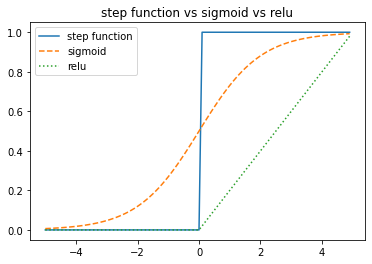

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def step_function(x):
    y = x > 0
    return y.astype(int) #출력 자료형을 int로 변환, np.int 보다 그냥 int를 쓰는 것을 권장함

def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0, x/5) # /5는 편의상 넣은 수치

x = np.arange(-5, 5, 0.1)
y1 = step_function(x)
y2 = sigmoid(x)
y3 = relu(x)
plt.plot(x, y1, label='step function')
plt.plot(x, y2, linestyle='--', label='sigmoid')
plt.plot(x, y3, linestyle=':', label='relu')
plt.title('step function vs sigmoid vs relu')
plt.legend()
plt.show()

# 3.3
### 행렬곱

In [ ]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
print(np.dot(a, b)) # np.dot이 행렬곱 연산을 하는 함수, 둘 다 1차원 벡터일 경우 내적
print()

a = np.array([1, 2])
b = np.array([3, 4])
print(a*b)
print(np.dot(a, b))


# 3.4
### 행렬 연산을 통한 신경망의 구현

##### WX+B= Y, X는 입력값을 받는 벡터이며, W는 가중치 정보가 적힌 행렬, Y는 다음 단계 입력 내지는 출력이 된다. B는 역치에 관한 값이다.

In [ ]:
def XOR(x1, x2):
    s1 = NAND(x1, x2)
    s2 = OR(x1, x2)
    return AND(s1, s2)

# XOR 대신 W라는 행렬을 통해 구현을 해 보자

W1 = np.array([[-0.5, -0.5], [0.5, 0.5]]) # W = [[NAND], [OR]]
W2 = np.array([0.5, 0.5])
B1 = np.array([0.9, -0.1])
B2 = -0.9

list_input = [[0, 0], [0, 1], [1, 0], [1, 1]]
print('Step 1')
step2 = list()
for input in list_input:
    temp = np.dot(W1, np.array(input)) + B1
    step2.append(step_function(temp))
    print('Input:', input, 'After operation:', temp,'\tAfter activation function: ', step_function(temp))

print()
print('Step2')
for input in step2:
    temp = np.dot(W2, np.array(input)) + B2
    print('After operation:', temp,'\tAfter activation function: ', step_function(temp))
    
    


# 3.5
### softmax function
$$ y_k = \frac{exp(a_k)}{\sum_{i=1}^{n}exp(a_i)}$$

소프트 맥스 함수의 총합은 반드시 1이 되며, 이는 확률과 밀접한 연관이 있다.
     즉 확률과 관계된 활성화 함수이다.

지수함수가 인자로 들어있기 때문에 입력값이 조금만 커져도 연산할 때 숫자가 매우 커지기 때문에
컴퓨터 연산으로는 불안정해지기 쉽다. 따라서 분모와 분자를 일정 값으로 나눠주는 절차를 거친다.

$$ y_k = \frac{Cexp(a_k)}{\sum_{i=1}^{n}Cexp(a_i)}$$

혹은

$$ y_k = \frac{exp(a_k + logC)}{\sum_{i=1}^{n}exp(a_i + logC)}$$

이 때의 C는 주로 $a_i$ 중 가장 큰 값으로 한다.

In [ ]:
def softmax(x):
    max = np.max(x)
    exp_a = np.exp(x-max)
    sum = np.sum(exp_a)
    y = exp_a/sum
    
    return y

a = np.array([0.3, 2.9, 4.0, 25.1, 0.002])
print(softmax(a), np.sum(softmax(a)))


        

# 3.6
### MNIST 데이터셋을 통한 손글씨 숫자 인식 프로그램 작성
##### pip install mnist.py 명령을 하면 python\python310\lib\site-packages 폴더에 해당 파일(모듈)이 설치한다.

아래는 mnist 모듈 전체 코드이다.
<pre>
<code>
from __future__ import annotations
from dataclasses import dataclass
from functools import cached_property
from pathlib import Path
from random import shuffle
from typing import Generator, Tuple
import zlib

import numpy as np
import requests


LabeledImage = Tuple[np.array, np.array]


@dataclass(frozen=True)
class Dataset:
    images: np.array
    labels: np.array

    def __post_init__(self) -> None:
        assert len(self.images) == len(self.labels)

    def __len__(self) -> None:
        return len(self.images)

    def __getitem__(self, index: int) -> LabeledImage:
        return self.images[index], self.labels[index]

    def __setitem__(self, index: int, value: LabeledImage) -> None:
        self.images[index] = value[0]
        self.labels[index] = value[1]

    # 학습에 있어서 중요한 함수, 데이터셋 중 일부를 추출한다.
    def minibatches(self, batch_size: int) -> Generator[Dataset, None, None]:  
        """Yield chunks of size batch_size from shuffled images and labels."""
        shuffle(self)
        for index in range(0, len(self), batch_size):
            yield self[index:index + batch_size]


@dataclass(frozen=True)
class MNIST:
    url_base: str = 'http://yann.lecun.com/exdb/mnist'
    cache_dir: Path = Path('/', 'tmp', 'mnist')

    @cached_property
    def train_set(self) -> Dataset:
        return Dataset(
            self.load_images('train-images-idx3-ubyte.gz'),
            self.load_labels('train-labels-idx1-ubyte.gz'),
        )

    @cached_property
    def test_set(self) -> Dataset:
        return Dataset(
            self.load_images('t10k-images-idx3-ubyte.gz'),
            self.load_labels('t10k-labels-idx1-ubyte.gz'),
        )

    def __post_init__(self) -> None:
        self.cache_dir.mkdir(parents=True, exist_ok=True)

    def raw_bytes(self, filename: str, offset: int) -> np.array:
        cached_file = Path(self.cache_dir, filename)
        if not cached_file.exists():
            with requests.get(f'{self.url_base}/{filename}') as resp:
                resp.raise_for_status()
                with open(cached_file, 'wb') as f:
                    f.write(resp.content)
        with open(cached_file, 'rb') as f:
            raw_bytes = zlib.decompress(f.read(), 15 + 32)
        return np.frombuffer(raw_bytes, '>B', offset=offset)

    def load_images(self, filename: str) -> np.array:
        """Return zero-to-one scaled images as rows of a matrix."""
        return self.raw_bytes(filename, offset=16).reshape(-1, 784) / 255 #밝기를 1/255로 낮춤으로써 밝기가 0~1 사이로 조정된다

    def load_labels(self, filename: str) -> np.array:
        """Return one-hot encoded class labels as rows of a matrix."""
        return np.eye(10)[self.raw_bytes(filename, offset=8)]

</code>
</pre>

In [ ]:
import sys, os
from PIL import Image
from mnist.mnist import MNIST #mnist 패키지 폴더의, .mnist mnist.py 모듈파일에서, MNIST 클래스를 들여온다

BRIGHT = 255
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img)) # uint8은 unsigned 8bit int의 줄임말로, 0~255 사이의 값을 말한다.
    pil_img.show()

train_data = MNIST().train_set # index 0~59999, 즉 6만개의 이미지가 있다.
test_data = MNIST().test_set
x_train, t_train = train_data.images*BRIGHT, train_data.labels
x_test, t_test = test_data.images*BRIGHT, test_data.labels

# .train_set은 2차원인 사진을 1차원으로 변화시켰기 때문에 2차원을 복원하는 과정을 거쳐야 한다.
# 밝기가 normalized 되었기 때문에 255배를 해줘야 한다. 안 그러면 인간의 눈엔 까만 배경만 보임
img = x_train[0].reshape(28, 28) # reshape는 비파괴 함수
img_show(img)



# 4.2
### 손실 함수
손실함수의 절대값이 가능한 한 작아야(0에 가까워야) 하며, 손실함수의 미분값이 0이 되는 지점을 찾아나간다.

### 4.2.1
##### 오차제곱합( Sum of Squares for Error, SSE )

$$ E = \frac{1}{2}\sum_{k}(y_k - t_k)^2 $$
y는 신경망 학습에 의한 응답값, t는 참값이라고 보면 된다.

### 4.2.2
##### 교차 엔트로피 오차( Cross Entropy Error, CEE)

$$ E = -\sum_{k} t_klogy_k $$

In [ ]:
def sum_square(y: np.ndarray, t: np.ndarray) -> float:
    return 0.5*np.sum((y-t)**2)

In [ ]:
def cross_entropy_error(y: np.ndarray, t: np.ndarray) -> float:
    delta = 1e-7 # 로그함수의 점근선 파탄을 막기 위한 값
    return -np.sum(t*log(y+delta))

### 4.2.3
##### 미니배치

In [ ]:
BRIGHT = 255

train_data = MNIST().train_set # index 0~59999, 즉 6만개의 이미지가 있다.
test_data = MNIST().test_set
x_train, t_train = train_data.images*BRIGHT, train_data.labels
x_test, t_test = test_data.images*BRIGHT, test_data.labels

print(x_train.shape) #28*28 이미지가 784의 1차원 정보로 변환되었고, 60000장의 이미지가 있다.
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

sample = train_data.minibatches(7) # sample은 제너레이터, 튜플을 반환하는데, [0]은 이미지, [1]은 라벨이다
sample_image = next(sample)[0]*BRIGHT
for arr in sample_image:
    img_show(arr.reshape(28, 28))
    

In [ ]:
def diff(f: function, x: float):
    h = 1e-4
    return (f(x+h)-f(x-h))/(2*h)

In [ ]:
def num_grad(f: function, x: np.ndarray):
    h = 1e-4
    grad = np.zeros_like(x) # x와 형상은 같되 인자들이 모두 0인 ndarray
    
    for idx in range(x.size):
        temp = x[idx]
        x[idx] = temp + h
        fxh1 = f(x)
        
        x[idx] = temp - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1-fxh2)/(2*h)
        x[idx] = temp
        
        return grad

# 4.5
### 학습 알고리즘 구현

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mnist.mnist import *


BRIGHT = 255
LEARNING_RATE = 0.01

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img)) # uint8은 unsigned 8bit int의 줄임말로, 0~255 사이의 값을 말한다.
    pil_img.show()

# 활성화 함수
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))

def softmax(x: np.ndarray) -> np.ndarray:
    max = np.max(x)
    exp_a = np.exp(x-max)
    sum = 1/np.sum(exp_a, axis=1)
    for idx in range(len(exp_a)):
        exp_a[idx] = sum[idx]*exp_a[idx]
    
    
    return exp_a

def cross_entropy_error(x: np.ndarray, t: np.ndarray) -> float:
    delta = 1e-7 # 로그함수의 점근선 파탄을 막기 위한 값
    err = -np.sum(t*np.log(x+delta))
    return err


def num_grad(f, x: np.ndarray):
    h = 1e-4
    grad = np.zeros_like(x) # x와 형상은 같되 인자들이 모두 0인 ndarray
    
    for idx in range(x.size):
        temp = x[idx]
        x[idx] = temp + h
        fxh1 = f(x)
        
        x[idx] = temp - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1-fxh2)/(2*h)
        x[idx] = temp
        
        return grad



# 신경망
class TwoLayerNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)
    
    
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = sigmoid(np.dot(x, W1) + b1)
        a2 = softmax(np.dot(a1, W2) + b2)
        
        return a2
    
    
    def loss(self, x, t):
        y = self.predict(x)
        #print(y, t)
        return cross_entropy_error(y, t)
    
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) # axis = 0 이면 각 '열'의 최대값의 인덱스를 어레이 형태로 반환
        t = np.argmax(t, axis=1) # axis = 1 이면 각 '행'의 최대값의 인덱스를 어레이 형태로 반환 None이면 평탄화해서 인덱스 반환
        accuracy = np.sum(y==t)/float(x.shape[0])
        return accuracy
    
    
    def gradient(self, x, t):
        h = 1e-4
        grads = {}
        for key in self.params:
            grads[key] = np.zeros_like(self.params[key].flatten())
            store = self.params[key]
            manipul = self.params[key].flatten()
            for idx in range(manipul.size):
                temp1, temp2 = manipul[idx] + h, manipul[idx] - h
                manipul[idx] = temp1
                self.params[key] = manipul.reshape(*self.params[key].shape)
                f_temp1 = self.loss(x, t)
                
                manipul[idx] = temp2
                self.params[key] = manipul.reshape(*self.params[key].shape)
                f_temp2 = self.loss(x, t)
                
                add_val = (f_temp1 - f_temp2)/(2*h)
                
                self.params[key] = store
                grads[key][idx] = add_val
                
            
            grads[key] = grads[key].reshape(*self.params[key].shape)
                
                
        return grads
    
    
train_data = MNIST().train_set # index 0~59999, 즉 6만개의 이미지가 있다.
test_data = MNIST().test_set

training_material = train_data.minibatches(100)


#=======================================================
network = TwoLayerNetwork(784, 50, 10)
acc = []
i=0
j=0
for material in training_material:
    x = []
    j += 1
    pred = network.predict(material[0])
    loss = network.loss(material[0], material[1])
    acc =  np.count_nonzero(pred.argmax(axis=1)-material[1].argmax(axis=1))
    print("trial:{:3d}\npredict:    {}\nreal value: {}".format(j, pred.argmax(axis=1), material[1].argmax(axis=1)))
    print(f'Accuracy:{(len(pred)-acc)*100/len(pred):3.2f}%')
    print(f'total loss: {loss:3.2f}\n')

    #img = material[0][idx].reshape(28, 28)*255 # reshape는 비파괴 함수
    #img_show(img)


    x.append(network.accuracy(material[0], material[1]))
    g = network.gradient(material[0], material[1])
    


    network.params['W1'] -= LEARNING_RATE*g['W1']
    network.params['W2'] -= LEARNING_RATE*g['W2']
    network.params['b1'] -= LEARNING_RATE*g['b1']
    network.params['b2'] -= LEARNING_RATE*g['b2']


    


        
    

trial:  1
predict:    [7 7 7 7 7 7 7 7 7 8 7 7 7 7 8 7 7 7 7 7 7 7 7 7 7 7 7 8 7 7 7 7 7 7 0 7 7
 7 7 7 7 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0
 7 7 7 7 7 7 7 7 8 7 7 7 7 7 7 6 7 7 7 7 7 0 7 7 7 7]
real value: [5 5 5 4 0 2 5 2 4 1 1 1 9 6 1 5 3 3 3 9 1 9 1 9 0 0 6 1 2 7 1 1 2 2 4 2 3
 9 1 2 0 2 3 6 3 2 8 7 9 9 3 9 9 1 3 5 6 1 4 2 9 4 3 7 2 6 7 3 8 6 3 5 6 4
 7 5 5 7 4 0 3 6 1 4 6 3 3 3 3 4 4 1 9 6 7 4 1 7 7 7]
Accuracy:10.00%
total loss: 846.40

trial:  2
predict:    [4 8 6 4 4 6 6 2 4 1 4 6 4 4 4 3 4 1 6 4 4 8 4 4 4 4 4 4 4 8 4 4 4 4 8 6 4
 1 4 4 4 4 4 6 6 4 4 4 6 4 4 4 4 4 6 4 9 4 4 4 4 1 8 4 4 6 1 4 4 4 4 6 4 1
 4 4 4 4 4 4 4 4 8 9 1 4 2 4 4 1 4 4 4 4 4 4 1 4 4 4]
real value: [0 1 4 5 6 3 5 9 6 7 3 5 6 0 6 9 0 1 8 7 0 1 7 1 1 0 8 7 2 2 3 4 4 8 1 0 6
 4 6 7 1 4 9 0 0 9 8 3 0 0 9 0 4 7 0 4 1 6 5 9 7 1 2 6 7 5 1 1 5 4 8 8 4 2
 6 0 0 6 9 4 4 6 1 3 8 0 2 7 6 2 6 4 6 6 9 6 1 3 3 4]
Accuracy:16.00%
total loss: 558.19

trial:  3
predict:    [1 1 8 0 1 1 6 6 0 0 9

trial: 19
predict:    [4 7 2 7 7 3 9 4 6 8 3 1 1 0 9 8 7 7 5 0 5 4 6 8 5 6 7 7 2 0 6 7 3 3 8 7 2
 5 8 7 0 3 0 1 8 1 5 3 1 5 7 4 1 1 6 6 3 7 5 7 4 0 7 5 3 3 4 1 5 5 8 0 4 5
 4 8 0 1 8 9 5 6 9 8 0 1 5 7 5 8 5 1 3 8 7 9 3 3 5 3]
real value: [9 9 9 7 7 3 9 4 6 3 3 1 1 0 8 7 5 3 5 0 6 4 8 2 5 6 7 7 3 4 4 7 3 3 8 7 7
 5 1 7 8 3 6 1 1 1 5 2 1 5 2 4 1 1 6 6 3 7 6 7 9 0 4 8 3 3 4 1 3 3 7 6 4 5
 9 8 0 8 2 4 9 9 6 9 9 1 3 7 5 1 8 7 3 8 7 8 5 6 5 3]
Accuracy:55.00%
total loss: 160.42

trial: 20
predict:    [9 8 9 3 2 8 1 7 6 3 3 0 9 4 9 3 3 5 7 3 8 2 3 8 4 8 2 2 5 7 4 1 1 0 7 8 1
 6 2 1 0 0 9 5 0 8 3 2 6 3 6 7 1 3 4 3 2 4 3 3 1 0 2 4 0 4 5 6 8 8 9 5 2 0
 3 6 3 3 1 7 4 9 0 4 9 3 6 4 4 3 1 2 8 3 2 2 3 3 3 5]
real value: [7 8 3 3 2 1 1 7 6 3 6 8 9 4 4 6 2 5 2 3 2 2 9 8 2 8 0 2 6 7 9 1 1 0 7 8 1
 6 0 3 0 0 9 5 0 7 2 2 6 2 6 7 1 3 4 4 0 4 3 5 1 0 0 5 0 4 0 3 8 8 7 6 6 0
 3 9 2 3 2 7 4 9 0 9 9 3 2 7 2 3 1 9 8 3 6 2 3 3 3 8]
Accuracy:60.00%
total loss: 151.76

trial: 21
predict:    [0 4 1 7 7 4 7 3 2 3 6

trial: 37
predict:    [7 5 9 3 7 5 1 6 9 8 7 9 9 3 3 1 7 3 4 8 7 9 1 6 4 5 1 8 7 7 0 3 3 4 6 2 0
 4 3 1 2 5 5 5 3 3 5 0 4 5 6 2 1 6 6 3 1 5 3 3 3 7 1 6 4 2 4 3 9 6 4 1 4 4
 9 0 9 2 4 9 8 7 6 5 4 4 5 3 1 6 9 0 5 4 1 9 3 1 1 6]
real value: [4 9 9 3 3 9 1 6 8 8 7 7 4 3 2 1 7 5 4 8 9 9 1 9 4 5 1 8 7 7 0 0 3 8 6 6 5
 2 2 1 5 0 5 9 9 3 3 0 9 5 6 2 1 4 6 7 9 5 3 3 6 7 1 2 8 3 4 3 2 6 4 8 7 4
 9 0 9 9 4 9 3 1 6 9 7 4 3 3 1 9 9 8 3 2 2 2 3 1 1 6]
Accuracy:55.00%
total loss: 122.76

trial: 38
predict:    [4 1 1 8 3 4 8 3 3 9 5 0 0 2 9 8 9 9 4 8 3 6 3 7 8 8 9 6 2 0 4 4 6 0 2 1 6
 6 3 9 8 1 8 2 0 6 9 9 7 6 9 9 1 1 7 2 3 3 3 0 7 0 7 7 3 9 0 3 7 0 6 8 3 0
 5 3 3 3 7 4 7 3 5 2 4 7 2 7 0 0 6 9 5 2 9 6 9 2 0 3]
real value: [4 1 1 2 3 4 5 6 9 4 5 5 0 2 9 6 8 5 4 8 3 6 3 9 6 8 9 6 2 0 4 4 6 0 2 6 6
 9 6 3 8 1 8 0 0 6 9 8 7 6 7 7 8 9 7 2 3 2 3 8 7 0 7 4 3 3 3 8 7 4 6 8 6 0
 5 3 5 3 7 4 7 4 9 2 4 6 2 0 0 0 6 9 5 4 4 6 0 5 0 6]
Accuracy:61.00%
total loss: 131.41

trial: 39
predict:    [9 6 0 1 3 6 4 1 3 5 6

trial: 55
predict:    [1 1 9 7 8 1 1 2 6 4 6 7 1 4 6 1 7 7 9 0 7 6 3 0 9 7 0 8 1 6 2 9 4 6 9 7 9
 9 4 7 7 5 9 0 7 6 1 0 6 2 0 6 6 8 1 7 3 8 5 7 1 3 3 6 8 8 3 5 0 8 3 8 7 1
 3 3 0 9 1 2 7 6 0 4 6 0 6 6 3 7 1 2 1 3 0 4 4 6 2 9]
real value: [1 1 3 7 1 8 1 2 6 9 8 7 1 4 6 1 7 9 8 0 7 6 3 0 4 5 0 8 1 6 8 7 4 3 9 7 9
 2 4 7 7 5 9 0 7 6 1 0 0 0 0 4 6 8 1 7 5 6 5 8 1 3 3 6 5 7 8 5 2 8 3 8 7 1
 9 3 0 9 1 2 7 6 0 4 6 0 4 6 3 7 1 6 1 3 8 4 4 6 2 7]
Accuracy:72.00%
total loss: 79.33

trial: 56
predict:    [4 3 8 6 6 6 3 6 4 4 6 0 8 9 3 5 7 5 3 3 2 6 3 8 3 6 4 3 5 0 2 6 3 1 0 7 4
 4 8 4 2 9 4 4 3 1 6 2 1 5 9 5 6 2 6 0 8 8 5 9 0 3 6 3 7 6 4 8 1 1 5 2 5 3
 3 5 8 1 4 3 6 5 6 0 6 6 7 6 4 3 7 0 8 1 3 3 2 8 8 1]
real value: [4 5 0 6 6 6 9 6 4 4 9 0 2 0 9 3 7 5 3 3 2 2 8 8 3 6 4 2 7 0 2 6 3 1 0 7 4
 4 8 6 2 9 4 6 3 1 6 2 1 5 9 5 2 2 7 0 8 8 5 9 0 3 6 3 7 6 2 0 1 8 5 2 8 3
 4 5 8 1 4 3 6 0 6 2 6 6 9 6 9 3 5 8 8 1 3 3 3 2 8 6]
Accuracy:70.00%
total loss: 112.00

trial: 57
predict:    [1 1 5 9 3 8 2 7 1 3 7 

trial: 73
predict:    [9 5 1 0 1 1 7 3 9 5 7 2 8 6 5 5 3 7 3 6 6 8 2 1 3 1 9 6 8 1 1 3 5 1 4 5 3
 9 5 8 5 0 9 3 7 3 2 0 0 4 2 1 1 2 6 0 4 8 9 2 3 9 8 5 9 9 8 8 5 2 2 3 6 9
 3 6 5 1 6 2 7 7 9 1 1 1 0 3 7 6 3 0 9 4 3 9 6 9 9 3]
real value: [9 8 1 0 1 9 7 3 9 3 7 2 6 4 5 5 3 7 3 6 6 5 2 1 9 1 7 6 8 1 1 3 5 1 7 2 3
 9 5 8 5 5 4 3 7 3 2 5 0 9 2 1 1 2 6 8 4 8 9 7 3 9 8 1 4 9 8 8 5 8 2 3 9 9
 3 6 5 1 6 2 7 7 9 1 1 1 0 3 7 6 5 0 9 9 7 9 6 9 9 3]
Accuracy:77.00%
total loss: 70.46

trial: 74
predict:    [4 3 9 6 9 6 9 1 4 4 7 6 3 7 2 8 7 6 4 8 8 9 3 0 9 3 9 8 5 2 7 0 5 4 1 9 8
 1 2 6 3 7 1 9 7 5 7 0 6 9 6 3 0 9 7 0 9 2 9 4 8 3 0 9 5 1 0 8 0 0 5 9 4 3
 2 0 6 9 6 1 6 2 0 5 8 0 5 4 7 9 6 9 6 1 1 7 7 1 0 6]
real value: [5 8 9 6 9 6 7 1 4 4 7 6 3 7 2 8 5 6 4 2 8 8 3 8 4 3 4 2 5 2 7 0 0 4 1 4 8
 1 2 2 5 7 1 4 7 3 9 0 8 8 9 3 0 9 7 0 9 2 4 2 8 2 0 9 8 1 0 8 0 8 0 9 4 5
 2 2 6 7 6 1 6 2 0 5 8 0 5 4 7 7 6 4 6 1 1 7 7 1 0 6]
Accuracy:69.00%
total loss: 83.57

trial: 75
predict:    [1 1 1 4 1 8 3 8 2 2 9 5

trial: 91
predict:    [6 5 3 3 8 3 3 5 3 1 3 5 2 1 1 1 8 8 4 3 1 5 3 4 9 1 9 4 7 5 9 5 0 8 7 1 1
 1 6 0 1 7 0 7 6 5 1 1 1 4 3 8 3 5 9 1 1 3 6 5 9 1 8 5 9 0 0 5 9 8 5 3 3 7
 4 0 0 1 3 5 8 1 2 2 3 9 7 4 8 6 6 0 5 8 4 9 1 7 2 7]
real value: [6 5 3 8 8 8 3 3 3 1 5 3 2 1 1 1 8 8 4 2 1 5 3 4 7 1 9 4 7 0 4 3 0 8 7 1 8
 1 6 0 1 7 0 7 6 5 1 1 1 4 6 8 6 9 9 1 1 3 4 5 9 1 2 5 9 4 0 2 9 8 5 8 3 7
 4 0 0 2 3 5 3 2 2 2 3 9 7 4 4 6 6 0 5 4 4 4 1 7 2 7]
Accuracy:75.00%
total loss: 79.42

trial: 92
predict:    [0 8 3 8 1 8 7 1 3 2 4 3 3 7 2 0 1 4 5 5 7 2 1 6 0 5 0 7 7 5 7 1 7 6 8 1 7
 9 9 7 4 9 6 3 8 7 5 3 1 8 1 8 4 8 8 1 5 2 6 7 3 0 0 8 6 2 0 6 2 8 3 3 7 1
 2 8 6 9 1 1 8 6 3 0 2 7 1 5 9 9 0 7 9 3 5 4 6 5 5 1]
real value: [6 8 3 8 1 8 7 5 9 2 4 3 3 7 2 0 1 8 5 5 7 1 1 6 0 5 0 7 7 5 7 1 9 6 8 3 9
 9 9 7 9 9 6 3 8 7 5 8 1 5 1 5 4 8 8 1 5 2 8 7 5 0 0 8 6 6 0 6 5 8 3 3 0 9
 7 8 6 9 1 1 8 6 8 0 8 7 1 3 9 7 0 7 7 5 5 4 6 5 8 1]
Accuracy:74.00%
total loss: 104.30

trial: 93
predict:    [1 6 7 4 8 0 7 7 4 9 6 

trial:109
predict:    [3 5 1 5 1 0 9 3 7 5 4 7 1 5 3 7 3 1 9 7 9 0 4 1 9 3 9 3 3 9 6 4 7 1 9 0 9
 4 7 5 8 7 5 4 7 3 2 3 9 7 5 7 0 7 5 4 9 5 6 5 7 8 8 1 2 2 2 0 6 9 6 1 6 5
 4 5 9 6 3 9 1 4 3 4 8 9 1 4 2 4 4 6 9 5 9 8 5 7 3 9]
real value: [3 3 1 5 1 0 7 3 7 5 4 7 1 9 3 7 3 1 7 7 4 0 7 1 9 3 9 8 3 9 6 4 7 1 9 0 7
 4 6 5 8 7 5 4 9 3 2 2 0 7 2 7 0 7 5 4 9 0 6 3 5 8 8 1 2 2 8 8 6 9 4 1 6 3
 4 5 9 2 9 9 1 8 3 4 8 0 1 2 2 4 4 6 6 5 6 8 5 7 3 9]
Accuracy:73.00%
total loss: 81.09

trial:110
predict:    [4 3 0 2 0 4 8 9 5 4 1 4 1 9 3 2 2 4 5 7 6 5 6 1 3 5 7 8 3 4 4 9 8 0 7 9 6
 6 2 1 3 7 9 8 8 3 0 9 0 1 5 2 7 3 1 7 1 1 7 5 3 3 8 3 4 1 2 8 0 0 2 1 9 6
 1 4 3 8 4 2 9 4 2 0 1 8 0 3 5 0 8 5 2 8 4 8 9 4 1 3]
real value: [4 3 0 2 0 4 8 9 5 4 1 2 1 9 5 8 2 4 5 7 6 5 6 1 3 5 7 8 3 9 4 9 2 0 7 3 6
 0 2 1 3 3 4 8 8 7 0 9 0 1 4 2 1 3 1 9 1 1 7 5 3 3 8 3 4 1 2 8 0 0 5 1 9 6
 1 4 3 8 4 2 9 4 2 0 1 2 8 3 5 0 2 5 2 8 4 8 9 4 1 3]
Accuracy:83.00%
total loss: 64.71

trial:111
predict:    [9 7 6 2 1 4 1 6 3 7 8 4

trial:127
predict:    [8 8 7 1 4 7 7 8 8 5 5 3 4 3 2 3 2 1 0 3 8 8 4 5 8 1 5 3 9 7 1 5 3 1 0 3 5
 0 4 5 8 3 8 1 1 9 7 7 8 3 0 4 2 1 3 2 8 5 7 3 5 8 6 8 0 3 9 7 8 9 3 4 8 8
 1 0 4 5 1 2 8 1 5 8 7 6 1 8 4 8 6 2 2 3 7 9 7 9 6 9]
real value: [8 5 9 6 4 7 9 8 3 5 5 5 4 3 2 3 2 1 0 3 8 8 4 5 1 1 8 3 0 7 1 0 8 1 0 5 5
 0 4 5 8 9 5 1 2 9 9 7 8 3 0 7 2 1 3 2 0 5 7 8 2 8 6 8 0 3 9 7 2 9 3 2 8 8
 1 0 4 5 1 2 8 1 3 8 7 8 1 8 4 9 6 2 2 5 7 9 7 9 6 9]
Accuracy:74.00%
total loss: 81.30

trial:128
predict:    [8 5 1 6 4 1 9 7 4 8 5 7 9 0 3 9 5 1 1 7 1 0 4 5 8 0 5 7 1 2 5 8 7 5 3 7 7
 3 2 6 5 2 7 2 6 9 1 5 8 6 1 1 4 8 8 6 6 5 8 5 9 1 8 8 8 0 6 5 1 6 2 0 0 7
 8 0 7 7 0 7 0 1 4 8 1 5 2 7 0 8 0 2 7 2 9 2 8 9 7 2]
real value: [8 5 1 8 3 1 7 3 4 8 5 7 4 0 3 9 5 1 1 7 2 0 4 5 8 0 5 9 1 6 5 8 7 5 3 7 7
 3 2 6 3 2 9 3 6 9 1 5 8 6 1 1 0 8 8 6 2 5 8 5 4 1 8 8 8 0 6 5 1 6 2 0 0 7
 8 0 7 3 0 7 0 1 4 8 1 1 2 9 0 8 0 8 7 8 9 5 1 9 7 2]
Accuracy:79.00%
total loss: 73.07

trial:129
predict:    [0 5 2 7 8 3 8 5 1 1 1 5

trial:145
predict:    [8 3 2 8 7 7 0 9 7 9 1 6 2 6 3 4 5 4 5 9 4 8 6 9 0 3 9 7 7 6 3 7 6 6 5 9 0
 7 0 7 7 2 6 2 5 9 4 6 0 4 5 3 9 8 4 9 8 5 1 9 3 1 0 5 1 9 7 7 6 2 4 8 3 0
 5 7 9 9 3 2 1 1 7 0 6 8 4 5 7 0 2 1 3 4 7 0 5 9 9 8]
real value: [8 3 0 8 7 5 0 9 7 4 1 6 2 6 3 5 5 4 3 9 4 8 6 9 0 3 9 7 9 6 3 7 6 6 5 9 0
 7 0 7 7 2 6 2 5 4 4 6 0 6 5 3 9 8 4 4 8 2 1 9 3 1 0 6 1 9 7 7 6 2 4 8 3 0
 5 7 9 9 9 2 1 1 7 0 6 8 4 5 7 0 2 1 3 4 7 0 5 9 9 8]
Accuracy:88.00%
total loss: 38.78

trial:146
predict:    [1 9 3 1 6 5 9 1 8 0 1 2 3 9 9 1 8 5 3 0 2 1 3 8 6 9 3 8 8 2 2 9 8 2 0 8 8
 3 5 1 5 8 8 3 2 0 0 8 7 2 4 5 3 5 2 6 6 3 8 2 6 0 8 8 5 3 2 0 2 1 3 4 6 3
 2 2 9 6 6 1 0 3 4 0 5 7 1 0 2 5 3 7 9 8 8 8 0 6 5 9]
real value: [1 9 3 1 8 5 9 1 8 5 1 2 3 2 9 1 8 8 3 0 0 1 0 8 6 4 8 8 8 2 2 9 8 3 6 2 1
 2 5 1 5 8 8 3 2 0 0 8 7 2 4 5 2 5 2 6 6 5 8 2 6 0 8 3 5 3 0 8 2 9 2 4 6 5
 2 2 9 6 6 1 0 3 4 0 5 7 1 0 2 5 5 7 8 4 5 5 5 6 5 9]
Accuracy:73.00%
total loss: 63.33

trial:147
predict:    [0 6 0 2 9 0 6 6 0 5 5 4

trial:163
predict:    [7 9 2 0 0 6 8 1 1 3 8 4 8 6 0 3 2 2 0 6 5 1 1 8 7 5 4 8 1 7 0 2 6 5 3 2 4
 1 4 4 2 8 0 1 7 1 5 7 7 5 1 8 2 0 3 1 5 8 8 3 6 2 3 1 8 0 4 4 9 4 0 0 6 8
 0 9 7 4 0 3 9 3 8 7 8 6 3 0 0 4 8 0 4 4 3 1 2 2 1 1]
real value: [5 9 2 5 0 6 8 1 1 3 8 4 8 6 0 3 2 7 0 6 7 1 1 8 7 3 4 8 1 7 4 2 6 5 2 2 4
 1 5 4 2 0 8 1 7 1 5 7 7 5 1 8 2 0 1 1 5 8 8 8 6 2 3 1 9 0 4 4 8 4 0 0 6 3
 0 9 7 6 0 3 9 5 8 7 8 6 3 0 0 4 8 0 4 4 2 1 5 2 1 1]
Accuracy:81.00%
total loss: 56.84

trial:164
predict:    [7 9 6 0 3 4 4 1 2 9 1 3 7 9 6 1 4 3 6 3 2 1 0 2 8 0 2 4 6 4 9 3 3 6 4 4 7
 4 5 3 0 7 0 8 5 6 6 3 4 9 1 2 3 5 9 7 8 0 0 2 5 5 0 5 4 2 2 2 6 1 0 5 3 8
 5 2 3 2 1 6 6 4 8 5 1 3 0 4 6 2 5 0 3 4 7 9 9 8 9 4]
real value: [7 9 6 5 3 4 4 1 2 9 1 0 7 9 6 8 2 3 6 3 2 1 0 2 0 0 2 4 6 4 9 3 3 6 2 4 7
 4 5 3 0 7 0 8 5 5 6 3 4 9 1 2 3 5 9 7 3 2 0 2 5 0 0 8 4 2 2 2 6 1 0 5 3 0
 5 2 3 2 1 6 6 4 8 5 1 3 0 4 6 2 5 0 3 4 7 9 9 0 9 4]
Accuracy:87.00%
total loss: 54.65

trial:165
predict:    [9 0 1 8 1 2 1 6 0 2 0 6

trial:181
predict:    [7 4 5 8 6 1 7 9 6 1 3 7 5 1 9 8 1 6 1 9 6 5 8 5 7 5 5 1 5 1 7 9 5 1 2 4 2
 9 9 1 9 2 2 2 2 4 4 6 8 4 6 8 3 5 5 2 2 1 7 8 7 0 2 8 1 9 3 4 7 7 4 9 9 4
 6 8 4 7 2 4 1 0 4 9 2 8 0 8 4 9 6 7 9 8 5 1 2 5 5 6]
real value: [7 4 5 8 6 1 7 8 6 1 3 7 3 3 9 6 1 6 1 9 6 8 8 5 9 5 5 1 5 1 7 9 5 1 5 5 2
 9 3 1 9 7 2 2 2 2 4 6 8 4 6 8 3 9 1 2 2 1 7 8 7 0 9 5 1 9 3 4 7 7 4 9 9 4
 6 8 9 7 2 4 1 0 4 9 8 8 0 5 2 7 6 7 9 8 5 1 1 5 5 6]
Accuracy:79.00%
total loss: 63.22

trial:182
predict:    [1 3 3 9 9 7 9 4 1 9 7 2 5 4 2 8 1 0 0 3 6 3 9 3 6 1 4 5 0 7 3 7 7 1 6 7 0
 5 8 7 5 1 6 2 1 1 8 7 6 3 8 9 6 9 3 5 7 6 1 6 6 3 3 5 0 1 9 9 0 6 2 8 8 4
 9 1 1 3 5 5 6 6 3 9 4 5 6 6 2 9 4 7 4 0 7 3 9 7 3 0]
real value: [1 3 3 9 4 7 9 4 1 3 7 2 3 4 4 8 1 0 0 3 6 3 4 3 6 1 4 5 0 7 3 4 7 1 6 9 7
 5 4 7 8 1 8 2 1 1 8 9 6 3 8 4 6 9 3 3 7 6 1 6 6 3 3 5 0 1 9 3 0 6 2 6 3 8
 4 6 1 8 3 9 6 6 3 9 4 5 6 4 2 4 4 7 4 0 7 3 9 7 3 0]
Accuracy:75.00%
total loss: 72.14

trial:183
predict:    [8 6 3 4 1 0 0 3 1 7 8 5

trial:199
predict:    [2 6 9 8 7 9 0 2 4 3 8 6 8 6 0 2 9 5 3 3 0 2 4 9 1 7 5 1 5 2 1 2 9 2 3 1 0
 1 7 3 9 3 8 7 9 3 7 9 5 2 4 6 3 4 5 7 0 5 9 5 6 4 3 0 4 2 0 1 5 7 1 5 4 7
 1 9 9 7 0 9 8 6 8 5 0 0 4 3 7 7 5 5 7 8 6 1 1 7 5 4]
real value: [2 6 9 8 7 9 0 2 4 3 8 6 8 6 0 2 9 5 3 5 0 4 4 9 1 7 9 1 8 5 1 2 9 2 3 1 5
 1 7 3 9 3 9 7 9 3 7 9 5 6 4 6 3 4 5 7 7 5 9 5 6 4 3 0 4 2 0 1 8 7 1 5 4 7
 1 9 9 7 0 9 8 6 8 5 0 0 4 3 9 5 8 5 7 8 6 1 1 7 5 4]
Accuracy:87.00%
total loss: 44.30

trial:200
predict:    [3 6 9 5 0 3 0 6 7 4 9 0 5 8 4 6 7 2 0 6 1 5 0 6 7 6 7 2 0 0 8 0 5 2 7 0 4
 3 8 3 0 9 6 0 3 1 7 0 1 1 9 9 0 6 6 9 5 5 3 6 4 8 0 4 7 9 6 5 8 0 2 2 4 7
 9 8 9 1 4 3 2 5 6 6 3 4 0 1 9 7 9 3 6 5 8 8 8 2 9 8]
real value: [3 6 9 3 0 3 0 6 7 4 9 0 5 8 4 6 7 7 0 6 5 8 9 6 7 6 7 2 0 0 8 0 5 2 7 5 4
 3 8 3 0 9 6 0 3 1 7 0 1 1 9 9 0 6 6 7 5 5 3 6 9 8 0 4 7 9 2 5 8 0 2 5 4 7
 9 9 9 1 4 3 0 5 6 0 3 4 0 1 9 7 9 3 6 5 8 8 8 2 8 8]
Accuracy:86.00%
total loss: 55.21

trial:201
predict:    [6 3 9 8 2 3 0 5 7 9 3 6

trial:217
predict:    [6 5 2 4 8 0 9 0 1 3 1 1 6 8 8 0 3 6 3 2 3 1 1 5 0 2 0 6 2 1 2 6 6 1 0 2 7
 9 6 2 1 1 0 3 3 8 4 4 9 7 3 3 5 1 2 3 4 3 0 9 9 9 0 1 7 6 6 8 8 5 2 8 2 8
 1 8 4 8 8 8 8 9 9 9 3 7 0 3 6 8 6 1 0 3 6 1 3 0 8 9]
real value: [6 6 2 4 8 0 9 0 1 3 1 1 6 8 8 8 3 3 3 2 3 1 6 5 0 3 5 0 2 1 2 0 6 1 0 2 7
 4 6 2 5 1 0 3 3 5 4 4 9 7 8 8 5 1 2 3 4 3 0 9 9 4 0 1 7 6 6 8 8 5 2 8 2 8
 1 8 4 8 8 3 8 7 9 7 5 9 0 3 6 8 6 2 0 3 6 7 3 0 8 9]
Accuracy:79.00%
total loss: 55.50

trial:218
predict:    [3 7 1 2 1 3 0 4 7 1 6 4 6 8 0 8 0 6 7 3 3 1 1 8 6 2 9 1 1 3 4 5 1 8 5 4 1
 8 6 9 7 9 8 1 7 6 0 9 4 0 6 8 7 7 2 9 7 2 5 1 6 0 8 8 7 4 2 3 6 8 9 2 1 2
 3 7 1 9 8 7 5 1 7 4 2 3 9 3 2 3 4 1 2 9 8 3 9 7 6 4]
real value: [2 7 1 2 1 3 0 4 7 1 6 2 6 8 8 5 9 6 7 3 5 2 1 3 6 2 9 1 1 3 4 5 1 3 5 5 1
 5 6 9 7 9 2 1 7 6 0 9 4 0 6 8 7 7 3 9 7 2 5 1 6 0 8 8 4 6 3 3 6 8 9 1 1 2
 3 7 1 9 8 7 9 1 7 4 2 3 3 2 2 8 4 1 0 9 8 3 9 7 6 2]
Accuracy:77.00%
total loss: 69.14

trial:219
predict:    [7 2 8 9 3 8 2 3 8 5 5 5

trial:235
predict:    [7 1 1 2 8 3 0 8 4 8 9 6 9 1 0 3 1 1 8 9 2 1 4 1 9 7 1 2 2 8 6 7 3 9 7 5 4
 7 9 1 5 4 2 8 8 1 0 1 5 0 1 6 1 1 6 4 1 1 4 5 3 0 3 8 3 9 4 8 9 3 4 2 1 6
 8 2 8 8 4 7 5 7 8 1 3 3 8 4 7 3 9 1 3 3 5 2 2 3 5 7]
real value: [9 1 1 7 8 3 0 8 4 8 4 6 9 2 0 3 1 1 7 9 2 1 4 1 9 0 9 8 2 8 6 7 1 9 7 5 4
 7 9 1 5 4 2 8 8 1 0 1 3 0 1 6 1 1 6 4 1 1 9 5 3 0 3 8 3 9 4 8 9 3 5 2 1 6
 8 3 1 8 9 7 5 7 5 1 3 3 8 4 7 3 9 1 3 3 5 2 2 3 3 7]
Accuracy:83.00%
total loss: 56.08

trial:236
predict:    [2 8 4 4 2 6 4 3 1 0 4 7 8 2 0 9 1 5 6 9 8 7 1 4 7 0 0 4 8 1 2 7 2 2 2 9 9
 0 6 5 7 4 5 7 6 9 6 5 0 0 4 7 9 8 9 8 2 5 7 1 0 2 8 9 1 1 6 1 6 4 9 9 4 3
 0 6 9 2 9 0 5 2 0 2 2 1 1 3 6 6 0 3 0 3 2 3 9 3 0 7]
real value: [2 8 4 9 2 6 4 3 1 5 4 7 9 2 0 9 1 5 6 4 8 7 1 4 7 0 0 4 8 1 2 7 2 2 2 9 9
 4 6 5 7 9 5 7 6 8 6 9 0 0 4 7 0 8 9 4 2 5 7 1 0 8 8 3 1 6 6 1 6 4 9 7 4 1
 0 6 9 2 7 0 5 2 0 7 2 1 1 3 6 6 0 3 0 9 2 3 9 3 0 5]
Accuracy:81.00%
total loss: 56.88

trial:237
predict:    [3 9 4 1 5 9 1 0 1 0 4 4

trial:253
predict:    [2 0 5 4 1 9 0 8 7 0 0 8 6 1 5 3 1 1 9 7 0 8 0 0 6 3 9 8 8 3 2 4 6 5 4 4 1
 7 3 4 7 1 2 3 3 8 0 5 7 9 7 7 5 4 2 1 1 8 0 9 9 1 9 7 7 6 9 8 5 9 8 2 1 0
 0 9 8 9 5 4 8 7 6 5 7 3 8 9 6 6 1 2 1 6 7 9 7 7 5 3]
real value: [2 0 5 5 1 9 0 5 7 0 0 8 6 1 8 3 1 1 9 7 0 2 0 0 6 2 9 5 8 0 2 4 6 5 4 4 1
 7 1 4 7 1 2 3 5 8 0 5 7 4 7 4 0 4 2 1 8 2 0 9 9 1 9 7 7 6 9 8 6 9 8 2 1 0
 0 9 8 9 5 4 8 9 6 3 3 3 8 9 6 6 1 2 1 6 7 9 7 7 3 3]
Accuracy:81.00%
total loss: 51.63

trial:254
predict:    [5 3 3 2 7 7 6 7 6 8 1 4 4 8 0 4 4 7 1 5 4 8 8 7 5 6 0 0 5 5 8 4 3 4 5 4 7
 9 4 3 3 5 5 7 6 8 0 4 0 1 4 5 5 5 0 5 4 3 2 7 3 3 9 2 7 6 9 2 5 9 0 4 3 0
 9 3 4 9 4 7 6 7 1 7 9 3 9 7 8 4 1 4 1 0 9 9 3 7 5 2]
real value: [5 3 3 2 7 7 6 7 6 8 7 9 7 8 0 4 5 7 1 3 4 8 8 7 5 6 0 0 5 5 8 4 3 4 8 4 7
 9 4 3 3 5 5 7 6 8 0 4 0 1 3 5 5 5 0 3 4 3 2 7 3 3 9 6 7 6 9 5 3 9 5 4 3 0
 0 3 9 9 4 7 6 7 1 7 9 3 4 7 2 4 1 4 1 0 9 2 2 7 5 2]
Accuracy:82.00%
total loss: 50.87

trial:255
predict:    [3 6 5 7 9 2 3 4 7 6 0 7

trial:271
predict:    [9 3 5 0 1 5 0 2 7 7 1 9 8 4 7 3 6 4 3 2 1 7 0 9 1 5 9 3 4 8 2 3 3 2 6 2 1
 2 8 0 1 1 2 6 2 1 0 3 0 6 5 9 4 9 1 4 8 3 2 8 6 4 2 6 6 7 4 7 0 6 4 8 2 3
 3 2 9 6 1 2 4 4 9 4 6 1 7 3 9 9 0 1 0 8 6 3 5 9 6 7]
real value: [9 3 5 0 8 5 0 2 7 7 1 9 5 8 7 3 6 4 9 2 1 7 5 9 1 5 9 9 2 2 2 3 3 5 0 8 1
 2 8 0 1 1 2 6 2 1 6 3 0 6 8 9 4 9 1 4 8 3 2 8 6 4 6 6 6 7 4 7 0 6 4 8 2 5
 3 2 9 6 1 2 4 4 9 4 6 1 2 3 9 9 0 1 0 1 6 3 3 9 6 7]
Accuracy:82.00%
total loss: 61.18

trial:272
predict:    [0 6 2 8 2 3 9 4 9 2 1 8 9 4 6 3 7 4 1 1 9 9 8 4 5 2 3 2 8 3 7 9 3 3 5 4 3
 6 0 6 0 5 9 8 0 7 9 9 0 7 1 8 3 6 2 7 3 4 9 5 0 6 0 3 3 4 6 2 2 7 6 5 0 6
 7 1 4 7 0 4 0 1 0 0 8 2 7 8 7 5 7 2 3 9 0 2 9 6 9 0]
real value: [0 0 5 8 2 3 9 4 7 2 1 8 9 4 5 3 7 4 1 1 9 9 8 4 3 2 3 2 8 3 7 9 3 3 0 4 9
 6 0 6 5 5 9 8 0 7 9 9 0 7 1 8 3 6 2 7 3 4 4 5 0 2 8 3 3 4 6 2 2 7 2 2 0 2
 7 1 4 7 0 5 0 1 0 5 8 2 7 5 7 5 7 2 3 7 0 2 0 6 9 0]
Accuracy:81.00%
total loss: 58.48

trial:273
predict:    [2 4 3 5 3 7 0 8 4 9 5 0

trial:289
predict:    [3 4 1 7 9 2 5 2 2 7 2 9 6 4 9 1 6 7 6 8 3 5 0 6 2 0 6 0 0 8 6 3 0 9 6 7 6
 2 2 6 9 9 6 0 3 3 0 9 3 5 1 6 0 5 1 7 2 9 3 7 3 7 8 1 2 9 1 1 3 7 8 9 3 6
 5 3 1 5 1 0 2 4 0 6 5 8 6 9 6 2 6 6 1 4 2 4 2 7 4 2]
real value: [3 4 1 9 7 2 5 7 2 9 2 9 6 4 9 1 6 7 2 8 3 5 0 6 8 0 6 0 0 8 6 3 0 9 6 7 6
 2 2 6 4 9 8 0 3 3 0 9 3 5 1 6 0 5 1 7 2 9 3 7 3 7 8 1 9 9 1 1 3 7 3 7 3 6
 5 3 1 5 5 0 6 4 0 6 5 8 6 9 6 2 6 6 1 4 8 4 2 7 5 9]
Accuracy:84.00%
total loss: 42.70

trial:290
predict:    [2 0 8 1 0 1 2 0 8 5 9 8 9 6 3 3 4 7 6 7 0 0 8 8 7 4 9 5 2 7 1 6 5 6 0 1 9
 0 4 5 9 8 0 4 4 9 4 8 9 8 5 1 6 3 4 2 6 1 3 8 7 0 3 6 9 3 3 9 5 8 7 7 8 8
 6 1 7 0 5 4 7 3 8 3 5 9 8 1 8 5 8 5 5 4 9 2 2 3 9 6]
real value: [2 0 8 1 0 1 6 0 8 5 9 8 9 6 3 3 4 7 6 7 0 0 8 8 7 4 9 5 2 7 1 6 5 6 0 1 2
 0 4 5 9 8 0 4 4 9 4 2 9 8 5 1 5 8 4 2 6 1 3 8 7 0 1 6 9 3 8 9 5 8 7 7 5 8
 6 1 7 0 5 4 7 3 8 3 5 9 8 1 1 0 2 5 6 4 9 7 2 3 4 6]
Accuracy:86.00%
total loss: 55.29

trial:291
predict:    [1 4 0 1 2 8 4 8 7 5 2 5

trial:307
predict:    [3 6 3 5 9 4 3 0 9 1 0 9 0 3 7 7 7 1 4 1 7 1 4 5 7 4 1 0 0 1 7 4 7 4 8 1 5
 0 1 2 8 2 2 0 9 2 4 6 2 4 3 1 0 7 1 1 1 0 5 1 4 1 3 0 4 3 0 2 7 3 8 5 2 9
 9 5 2 5 0 4 9 6 6 9 7 6 8 7 5 9 7 1 8 2 0 4 2 6 9 1]
real value: [8 6 3 5 9 4 5 0 9 1 0 9 0 3 7 7 7 1 4 6 7 1 4 5 7 4 3 0 0 1 7 4 7 4 8 1 0
 0 1 2 8 2 2 0 9 2 4 6 3 4 3 1 0 7 1 1 1 0 5 1 1 1 2 0 4 5 7 9 7 8 8 5 3 9
 9 5 2 3 0 4 9 6 8 9 7 2 8 7 5 9 7 1 8 2 0 4 2 2 9 1]
Accuracy:83.00%
total loss: 61.12

trial:308
predict:    [1 8 9 3 8 9 8 0 3 4 4 1 7 9 0 4 3 2 7 8 7 3 8 5 0 8 3 5 3 5 8 6 4 6 1 8 9
 9 0 7 4 7 4 9 9 8 4 8 3 4 1 3 2 2 0 6 6 1 5 9 2 1 2 7 2 4 9 1 8 9 7 7 7 9
 3 3 4 6 7 6 8 4 8 5 4 0 1 0 9 1 1 4 4 8 4 4 0 6 5 7]
real value: [1 8 7 5 3 9 8 0 9 7 4 7 7 9 0 4 3 8 7 8 7 3 3 5 5 8 3 5 3 5 8 6 4 2 1 9 9
 9 0 7 4 7 4 9 9 8 4 8 3 4 1 3 2 2 0 6 6 1 6 7 4 1 2 7 7 4 9 1 8 9 7 7 7 9
 0 3 4 4 7 6 8 4 8 5 4 0 1 0 9 1 1 4 4 8 4 4 0 6 5 7]
Accuracy:83.00%
total loss: 53.30

trial:309
predict:    [6 1 6 7 9 2 8 2 7 9 5 4

trial:325
predict:    [7 5 6 4 7 9 4 8 4 7 4 0 4 3 5 9 3 2 8 0 0 3 4 1 4 7 6 6 4 1 3 6 4 2 2 9 6
 6 1 7 2 2 6 7 1 0 2 0 3 8 6 2 1 2 7 5 0 1 6 1 7 7 2 8 1 4 2 3 9 3 6 7 6 0
 3 3 9 5 0 3 8 1 8 6 6 6 1 5 1 2 3 3 7 9 6 8 2 4 6 4]
real value: [7 5 6 4 7 5 9 8 4 7 4 0 4 3 5 9 3 2 8 0 0 3 4 1 4 7 6 6 4 1 3 6 4 5 2 9 6
 6 1 7 2 2 6 7 1 0 2 0 3 8 6 2 1 2 7 5 0 8 6 1 7 7 5 8 1 4 5 3 9 8 6 7 6 0
 5 3 9 5 0 3 5 1 8 6 6 6 1 5 1 2 3 3 7 9 6 6 2 4 6 4]
Accuracy:90.00%
total loss: 36.01

trial:326
predict:    [5 6 3 4 0 2 9 6 6 1 1 9 6 8 1 8 1 8 8 8 8 3 6 4 9 5 7 7 2 3 8 3 5 6 3 7 4
 6 1 2 1 6 3 0 7 0 3 8 0 7 5 8 6 9 3 6 7 8 3 8 2 9 9 6 3 5 8 0 2 0 5 0 8 0
 9 9 7 6 4 1 5 8 9 9 1 0 3 1 0 4 7 7 7 0 7 1 6 1 3 6]
real value: [5 6 3 4 0 2 9 6 6 1 1 9 6 8 1 3 1 8 8 1 8 3 6 4 9 5 7 7 6 3 3 3 5 6 3 7 4
 6 1 5 1 6 3 0 7 0 3 8 0 7 3 8 6 9 3 6 9 8 3 8 2 9 9 6 9 5 8 0 7 0 5 0 8 0
 9 9 7 6 4 1 5 5 9 7 1 0 3 1 0 5 9 7 7 0 7 1 0 1 3 6]
Accuracy:86.00%
total loss: 38.15

trial:327
predict:    [3 8 9 0 3 7 6 9 6 8 3 6

trial:343
predict:    [7 9 9 5 0 7 8 4 6 2 2 4 4 0 4 3 2 0 5 7 1 3 7 1 9 2 6 3 4 9 4 8 0 9 2 9 3
 4 3 9 1 9 0 2 9 0 6 1 6 6 7 4 2 1 9 7 4 2 4 5 3 2 9 7 0 1 9 9 8 6 0 3 4 8
 8 2 1 6 4 3 6 1 7 2 9 8 3 9 9 7 4 3 9 2 8 9 3 4 4 0]
real value: [7 9 9 5 0 7 8 4 6 2 6 4 4 0 5 3 1 0 5 7 1 2 7 1 9 2 6 3 4 9 4 5 0 9 2 7 3
 4 5 9 1 9 0 2 9 0 6 1 6 6 7 4 8 1 5 7 9 2 5 5 3 2 9 7 0 1 4 9 8 6 0 4 4 3
 2 2 1 6 2 5 6 1 7 2 9 8 3 9 5 7 4 3 9 2 2 9 3 9 4 0]
Accuracy:80.00%
total loss: 47.47

trial:344
predict:    [9 6 9 6 3 7 4 2 7 5 9 0 9 5 0 6 4 6 4 9 7 1 7 7 0 6 3 6 3 3 7 5 0 7 7 7 1
 3 2 7 5 0 6 9 6 6 9 5 3 4 9 9 2 2 6 2 2 6 6 1 1 6 2 8 7 4 2 8 1 9 7 1 4 0
 0 2 1 0 8 0 8 1 9 7 0 0 6 7 1 3 2 1 0 7 7 6 3 1 5 9]
real value: [9 6 9 6 3 7 4 2 7 8 4 0 9 0 0 6 4 6 4 9 7 1 7 7 0 6 8 4 3 3 2 5 0 7 7 7 1
 3 2 7 5 0 6 9 6 6 9 5 3 2 9 8 2 4 2 8 2 6 6 1 1 6 2 8 7 4 2 5 1 8 8 1 4 0
 0 2 1 0 8 0 8 1 9 7 5 0 6 7 1 3 2 1 0 7 7 6 3 1 5 8]
Accuracy:84.00%
total loss: 43.48

trial:345
predict:    [0 5 8 1 8 0 1 0 2 6 1 3

trial:361
predict:    [8 8 8 1 7 6 9 9 4 6 7 6 7 9 9 8 6 7 1 3 0 2 4 1 1 7 8 9 2 9 0 7 8 1 5 0 6
 3 5 1 1 1 9 2 2 0 0 5 8 8 1 5 5 4 2 2 6 3 1 3 7 5 8 4 4 5 7 4 1 9 3 9 6 2
 8 5 6 6 8 7 7 9 4 8 2 7 9 3 7 7 6 4 1 8 7 1 8 8 5 9]
real value: [8 9 8 1 7 6 9 9 3 4 7 6 7 9 9 8 6 7 1 3 0 2 7 1 1 7 8 9 2 9 0 7 3 1 5 0 6
 3 5 3 1 1 4 3 2 0 0 5 8 8 1 5 6 8 2 2 6 3 1 5 7 3 8 4 4 1 7 4 1 9 3 9 6 2
 8 5 6 6 8 9 7 9 6 8 4 7 9 1 7 7 6 4 1 8 7 1 8 9 5 9]
Accuracy:82.00%
total loss: 47.93

trial:362
predict:    [5 8 0 3 0 3 3 6 9 9 8 9 1 2 8 8 3 1 8 5 0 8 0 1 6 1 1 1 3 1 1 9 9 5 6 0 2
 8 0 7 8 1 5 0 0 4 3 0 7 7 2 0 4 7 1 2 1 8 1 9 2 3 2 1 3 1 9 3 4 4 3 3 2 7
 5 2 1 4 6 0 6 8 8 0 8 1 6 4 2 8 7 1 8 5 7 1 9 4 4 8]
real value: [8 8 0 3 0 1 3 6 9 8 8 9 1 2 8 8 3 1 8 3 0 8 0 3 6 1 1 1 3 1 1 9 9 5 6 0 2
 8 0 7 8 1 5 0 0 9 3 0 7 7 2 5 4 7 1 4 1 8 1 9 2 5 2 1 3 1 9 3 4 4 3 3 2 7
 5 2 1 4 6 0 6 8 3 0 8 1 6 9 2 8 7 1 8 5 7 1 9 4 4 8]
Accuracy:89.00%
total loss: 32.31

trial:363
predict:    [8 2 8 9 3 6 2 0 1 1 0 8

trial:379
predict:    [9 1 0 2 1 3 1 8 8 4 4 9 8 1 1 8 6 5 8 0 1 1 6 4 7 0 1 1 6 6 5 9 5 0 5 4 2
 7 6 7 1 2 6 9 6 9 9 3 5 8 9 9 1 9 4 2 5 2 5 3 9 4 0 9 1 4 9 8 1 9 2 9 4 9
 3 3 6 6 1 4 9 1 9 1 2 2 4 5 7 1 8 9 5 2 2 8 9 5 4 8]
real value: [7 1 8 2 8 3 1 8 8 4 4 9 3 1 1 8 6 5 8 0 1 1 6 4 7 0 1 1 8 6 5 3 5 0 5 8 2
 7 6 7 1 2 6 9 2 9 8 3 5 8 9 9 2 9 4 2 3 3 5 3 9 4 0 5 1 4 9 8 1 8 2 9 4 9
 8 3 6 6 1 4 9 1 9 1 2 2 4 5 7 1 8 9 3 2 2 8 9 5 4 8]
Accuracy:84.00%
total loss: 55.66

trial:380
predict:    [3 0 0 3 4 7 0 5 4 7 7 8 8 7 8 3 6 0 5 2 4 4 7 6 8 6 1 0 9 1 9 4 4 9 1 7 6
 8 8 2 4 0 3 8 3 8 3 8 8 4 1 6 4 9 7 3 8 4 3 6 9 7 2 4 3 4 2 5 6 2 9 3 0 7
 1 2 0 7 9 7 1 0 6 9 3 0 7 8 6 7 2 6 3 4 3 7 8 8 1 0]
real value: [3 0 5 5 4 9 0 5 4 7 7 8 3 7 8 3 6 0 5 2 2 4 0 6 8 6 1 0 9 1 9 4 9 9 1 2 6
 8 5 2 4 0 5 8 3 8 3 8 8 4 1 6 4 9 7 3 8 4 0 6 4 7 2 4 8 4 2 5 6 2 9 3 0 7
 1 2 0 7 4 7 1 0 6 9 8 0 7 8 6 7 2 6 3 4 3 7 5 8 1 0]
Accuracy:84.00%
total loss: 36.28

trial:381
predict:    [7 1 8 6 5 3 2 3 8 9 2 3

trial:397
predict:    [7 6 2 0 3 5 8 1 1 9 8 2 8 1 6 2 9 4 2 9 7 5 2 3 1 8 0 8 0 3 8 8 5 6 5 2 2
 2 4 0 7 5 5 7 5 2 4 2 3 6 7 9 8 7 9 9 7 8 6 2 1 4 9 0 0 6 1 1 6 2 1 4 0 8
 0 9 6 7 4 1 4 3 8 5 2 9 7 0 8 0 5 8 3 9 3 0 1 0 6 7]
real value: [7 6 2 0 3 5 8 1 1 9 8 2 2 1 6 2 9 4 2 9 7 5 2 0 1 8 0 8 5 3 8 8 5 6 5 2 1
 2 9 0 7 5 5 7 5 2 4 2 1 6 7 9 8 7 5 9 7 8 8 2 5 4 9 0 0 6 2 1 6 2 1 9 0 8
 0 9 6 7 4 1 4 5 2 3 2 9 7 0 5 0 5 9 5 9 3 0 1 0 6 7]
Accuracy:83.00%
total loss: 45.04

trial:398
predict:    [0 2 9 5 1 0 5 6 1 8 6 9 9 7 9 5 4 1 1 0 7 7 4 1 0 6 9 3 2 0 7 3 2 0 1 6 4
 9 3 6 6 1 1 4 2 9 0 2 6 1 2 2 6 5 3 5 4 0 9 1 5 8 9 1 3 0 9 4 0 4 8 2 2 0
 2 1 2 8 6 6 9 7 5 7 6 9 4 9 7 5 5 3 1 8 6 3 6 1 0 5]
real value: [0 2 9 5 1 0 0 8 1 8 6 9 9 7 9 5 4 8 1 0 7 7 4 1 0 6 9 3 2 0 7 3 2 0 1 6 4
 4 3 6 6 1 1 4 2 9 9 2 6 1 8 2 6 5 3 5 4 0 4 1 5 8 9 1 2 0 9 4 0 4 8 2 2 5
 8 1 7 8 6 6 9 7 5 7 6 9 4 4 7 5 5 3 1 1 6 3 6 1 0 5]
Accuracy:87.00%
total loss: 41.02

trial:399
predict:    [6 9 9 6 7 3 5 5 4 1 3 5

trial:415
predict:    [2 1 8 9 4 4 7 2 4 0 1 1 9 6 1 9 8 6 5 4 2 3 6 5 0 0 0 6 4 7 2 1 5 4 6 0 6
 1 8 2 4 0 0 0 5 9 0 9 1 1 4 0 4 9 2 0 9 8 2 3 1 2 7 9 3 1 5 2 4 7 1 6 3 4
 0 3 0 0 5 0 5 9 2 6 1 2 8 2 9 9 9 0 5 3 0 4 7 4 4 9]
real value: [2 1 8 4 9 4 7 2 4 0 1 1 0 6 1 9 2 6 5 9 2 3 6 5 0 0 0 6 4 7 2 1 5 4 2 0 6
 5 8 5 4 5 0 0 5 9 0 9 5 1 4 0 4 9 8 0 9 8 7 1 1 2 7 9 3 1 5 2 4 7 1 6 2 9
 0 1 0 0 5 0 5 9 3 6 1 2 8 2 9 9 9 0 3 3 0 4 9 4 2 9]
Accuracy:80.00%
total loss: 55.62

trial:416
predict:    [1 8 9 6 1 2 9 1 5 8 6 9 8 6 8 1 6 8 0 1 3 5 5 9 1 5 5 5 0 4 2 4 3 9 9 1 2
 0 2 1 3 7 0 3 5 2 9 1 5 3 1 9 9 7 9 1 3 3 1 8 3 0 5 8 5 2 1 4 6 9 2 6 5 6
 9 7 7 0 0 6 8 9 1 7 8 9 9 5 1 6 0 2 8 7 6 3 6 9 1 5]
real value: [1 8 9 6 1 2 9 1 5 8 6 9 2 6 8 1 6 8 0 1 3 0 5 9 1 5 5 5 0 7 2 4 3 9 9 1 2
 0 2 1 8 7 0 3 5 2 9 1 5 3 1 9 4 7 9 1 3 3 1 8 8 0 6 8 5 2 1 4 6 9 2 6 5 6
 9 7 7 0 0 6 8 9 3 7 9 9 9 5 1 6 0 2 5 7 1 3 6 9 1 5]
Accuracy:89.00%
total loss: 39.18

trial:417
predict:    [3 9 7 9 7 4 0 8 5 2 3 3

trial:433
predict:    [7 3 1 1 6 1 4 7 0 5 8 1 2 1 5 0 6 8 9 1 4 5 7 2 0 7 0 1 6 7 9 5 9 0 5 4 2
 7 9 9 2 1 0 2 4 0 4 2 9 0 9 7 4 1 0 2 5 0 2 4 5 5 4 8 6 6 5 7 8 8 1 6 9 3
 1 2 5 7 2 3 8 6 2 3 4 7 9 2 6 6 3 7 6 3 4 1 2 8 7 8]
real value: [7 3 1 1 2 1 4 7 0 5 3 5 2 1 8 0 6 8 8 1 4 0 7 2 5 7 0 1 6 7 9 5 9 0 8 4 2
 7 9 9 2 8 0 2 4 0 4 2 9 0 9 7 4 1 0 2 5 0 2 4 5 5 4 8 4 6 5 7 8 8 1 6 9 8
 1 2 5 7 2 3 8 6 2 3 4 7 9 2 4 6 3 7 6 2 5 1 2 8 7 8]
Accuracy:86.00%
total loss: 34.96

trial:434
predict:    [9 7 0 9 3 6 8 3 0 4 4 1 7 1 1 2 4 2 2 8 4 3 4 0 8 6 7 4 7 9 7 4 7 4 7 7 3
 5 9 2 4 7 4 1 7 0 7 1 5 8 0 3 8 8 3 9 0 8 3 7 2 8 1 7 6 8 1 0 0 7 6 3 9 3
 7 9 8 9 1 5 3 0 6 3 2 4 1 7 4 1 5 3 1 0 2 2 3 7 2 9]
real value: [9 7 0 9 3 6 8 3 0 4 2 1 7 1 1 2 4 2 2 9 4 3 4 0 6 6 9 4 7 9 7 4 7 9 7 7 3
 5 3 2 5 7 2 1 7 0 2 1 5 2 0 1 5 8 3 9 2 8 3 7 2 8 1 7 6 8 1 0 0 7 6 3 9 3
 7 9 8 9 1 5 3 0 6 3 8 4 1 7 4 1 5 3 1 0 2 2 8 7 2 4]
Accuracy:84.00%
total loss: 47.61

trial:435
predict:    [5 8 0 5 9 6 5 8 6 9 5 1

trial:451
predict:    [9 0 5 2 5 4 3 3 4 9 1 5 9 5 2 3 9 1 2 1 2 2 0 7 9 2 9 1 1 6 7 7 2 4 4 0 7
 5 9 9 9 3 5 9 0 9 8 8 5 2 4 5 8 5 5 8 5 0 0 2 9 1 6 7 0 7 7 5 1 4 0 9 3 3
 4 6 7 5 0 1 2 1 1 7 9 5 5 0 6 8 2 1 8 0 3 0 2 4 6 3]
real value: [9 0 5 2 8 4 8 3 4 7 1 5 3 5 2 3 7 1 2 1 2 2 0 7 4 2 9 1 1 6 7 7 7 4 4 0 7
 5 9 9 4 3 5 5 0 9 8 8 3 2 4 3 8 5 5 0 5 0 0 2 4 1 6 7 0 7 7 5 1 2 3 4 3 3
 4 6 7 5 0 1 2 1 1 7 9 3 5 0 6 8 2 1 8 0 3 0 2 4 6 5]
Accuracy:82.00%
total loss: 48.89

trial:452
predict:    [7 7 4 4 6 0 3 3 6 7 7 3 4 7 6 6 2 3 2 7 6 7 8 3 5 3 0 2 1 2 4 8 9 2 7 4 2
 7 1 3 0 4 2 9 2 4 4 5 3 4 6 0 4 9 0 5 8 9 9 1 0 7 9 9 5 6 3 1 4 8 5 9 0 3
 0 4 2 3 1 7 2 0 0 1 6 1 6 0 4 7 7 9 6 0 8 1 8 3 0 3]
real value: [7 3 4 4 6 0 2 3 6 7 7 3 6 7 6 6 2 3 2 7 6 2 8 3 5 3 0 2 1 2 6 8 9 2 9 4 3
 7 1 3 0 4 3 9 2 4 4 5 3 4 6 0 9 9 0 5 8 9 9 1 0 7 9 9 5 6 3 1 4 8 5 3 0 3
 0 4 2 3 1 7 2 0 5 1 6 1 6 0 8 7 7 9 6 0 8 1 8 8 0 3]
Accuracy:87.00%
total loss: 46.94

trial:453
predict:    [8 0 9 5 8 7 9 5 7 1 8 6

trial:469
predict:    [5 5 5 8 1 9 7 9 7 6 7 6 0 2 2 7 1 8 0 0 9 1 0 4 7 8 4 7 3 4 7 5 7 4 4 4 2
 9 7 0 8 4 5 7 7 1 2 8 9 3 3 9 7 5 7 5 2 2 9 8 4 7 3 9 4 7 2 9 4 8 2 3 0 9
 1 1 0 5 2 1 0 1 6 0 6 4 1 3 6 7 5 6 8 0 4 6 9 9 1 7]
real value: [5 5 5 8 1 9 7 9 7 6 7 6 0 2 3 7 1 5 0 0 9 1 0 4 7 8 4 7 3 6 7 5 7 4 4 4 2
 9 7 0 8 4 8 2 7 1 2 8 4 9 3 9 7 5 2 5 2 2 9 8 4 7 3 9 4 7 2 9 6 8 3 3 0 9
 1 1 0 5 2 1 0 1 6 0 6 4 1 3 6 9 3 6 8 0 7 8 9 9 1 9]
Accuracy:85.00%
total loss: 56.34

trial:470
predict:    [0 3 0 1 8 9 5 2 0 4 7 9 9 7 1 0 0 1 2 2 7 8 1 7 0 7 9 0 0 7 4 9 5 3 5 6 4
 0 6 9 8 3 0 8 9 4 9 1 6 0 5 1 4 9 2 6 1 9 8 4 9 8 5 0 7 1 1 1 9 4 2 5 8 9
 8 6 4 2 9 1 4 7 6 0 7 5 9 9 6 1 9 0 7 1 7 5 3 6 1 4]
real value: [2 3 0 1 8 9 5 2 0 4 7 3 9 7 1 0 0 1 2 4 7 8 1 5 0 7 9 0 0 7 4 4 5 1 5 6 4
 0 6 9 8 3 0 8 9 4 9 1 6 6 5 1 4 9 2 6 1 9 3 6 4 8 5 0 9 1 1 1 9 4 2 5 8 9
 8 6 4 2 9 1 2 7 6 0 9 5 9 9 2 1 9 0 7 1 7 5 3 6 1 4]
Accuracy:86.00%
total loss: 40.87

trial:471
predict:    [0 1 3 2 2 6 3 3 1 9 1 6

trial:487
predict:    [6 8 4 3 5 4 1 0 6 6 7 9 8 6 1 2 0 4 5 7 1 4 8 4 1 8 8 4 1 4 1 0 3 3 5 9 8
 6 0 7 8 1 8 5 9 2 0 1 7 7 2 0 5 4 7 8 3 6 8 9 0 2 6 9 6 2 8 9 8 3 6 3 2 8
 4 7 7 7 8 6 5 0 2 5 9 0 9 5 3 8 7 0 0 7 0 9 6 6 7 2]
real value: [6 8 4 3 5 4 1 0 6 8 7 9 8 6 1 1 0 4 5 7 1 4 5 8 1 8 8 4 1 4 1 0 5 3 5 8 8
 6 0 7 8 1 6 5 9 2 0 1 7 7 2 0 3 4 7 8 3 6 8 9 0 2 6 9 6 2 8 9 8 3 6 3 7 8
 4 7 9 7 0 8 5 0 2 7 8 0 9 8 8 8 7 0 0 7 8 9 6 6 4 2]
Accuracy:82.00%
total loss: 63.47

trial:488
predict:    [5 2 5 4 3 8 5 7 2 4 7 4 7 8 3 7 5 3 5 9 2 4 3 9 1 8 1 8 8 2 4 3 5 9 2 6 4
 4 0 5 8 5 0 6 1 0 4 1 3 3 2 3 3 4 5 6 1 3 8 9 8 9 6 1 7 7 0 5 7 6 1 3 3 0
 8 2 3 8 1 6 8 5 9 7 3 1 6 4 8 5 0 0 0 9 9 6 2 4 8 7]
real value: [2 2 5 4 3 8 5 7 2 4 7 4 7 8 2 9 9 3 5 9 2 4 3 9 1 8 1 8 8 2 4 3 5 9 2 6 4
 9 5 5 8 5 0 6 1 0 7 1 3 3 2 5 3 4 5 6 1 3 8 9 5 9 6 1 7 7 0 5 7 6 1 1 2 0
 8 2 3 8 1 6 5 5 9 7 3 1 6 4 5 5 0 0 0 9 9 6 2 4 8 7]
Accuracy:87.00%
total loss: 32.08

trial:489
predict:    [5 1 6 6 2 9 1 7 3 7 2 0

trial:505
predict:    [9 1 7 4 6 3 2 3 8 3 0 3 7 5 7 1 8 3 2 4 2 6 1 1 3 1 0 6 8 9 5 5 4 6 3 3 6
 4 8 9 9 6 4 5 7 3 1 1 8 9 0 8 3 1 7 2 2 6 6 1 4 1 8 5 6 4 5 7 1 8 6 8 2 9
 6 7 5 3 3 5 8 7 3 8 6 5 6 1 6 5 5 7 5 6 5 0 7 0 3 1]
real value: [9 1 7 9 6 3 2 2 8 3 0 3 7 5 7 1 2 5 2 4 2 6 1 1 3 1 0 6 5 9 5 5 4 6 3 5 6
 4 8 9 9 6 4 5 7 3 1 1 8 9 0 8 2 1 7 2 2 6 6 1 4 1 0 5 6 8 5 7 1 5 2 5 2 0
 6 7 5 3 9 5 5 7 3 8 6 5 6 1 6 5 5 7 5 6 5 0 9 5 3 1]
Accuracy:83.00%
total loss: 51.99

trial:506
predict:    [6 9 1 6 0 7 0 5 9 9 0 5 5 8 9 1 4 8 3 1 1 4 1 0 2 4 4 5 7 9 2 4 2 0 2 2 1
 2 5 6 9 2 5 3 7 5 1 0 9 4 0 7 9 6 3 6 3 7 6 3 5 9 0 1 4 9 8 1 7 1 0 6 5 0
 4 9 9 1 8 3 5 8 2 9 5 9 4 9 5 4 1 3 1 1 3 5 5 1 6 6]
real value: [6 9 1 6 0 7 0 5 9 9 0 5 5 8 9 1 4 8 3 8 1 4 1 7 2 9 4 5 7 9 2 4 2 0 2 2 1
 7 5 6 9 2 3 3 7 4 1 0 9 2 0 7 8 6 3 6 3 7 6 3 5 9 0 1 2 9 6 1 7 1 0 6 6 0
 4 9 9 1 8 3 8 8 2 4 5 9 9 9 5 7 1 3 1 1 9 5 6 5 6 6]
Accuracy:82.00%
total loss: 46.84

trial:507
predict:    [2 1 2 1 0 3 9 9 9 8 2 3

trial:523
predict:    [0 5 0 8 3 1 1 1 4 1 9 5 2 9 6 4 6 6 2 3 2 6 9 4 0 6 7 2 0 2 0 8 6 2 2 3 7
 7 7 1 6 9 8 4 7 1 3 3 7 3 1 3 8 5 4 2 9 3 2 7 6 1 1 6 2 0 9 1 4 1 5 0 6 6
 1 7 8 1 9 6 2 3 5 2 4 6 1 9 6 7 0 5 9 6 6 6 1 1 4 2]
real value: [0 5 0 8 3 1 1 1 4 1 9 5 2 9 6 4 6 0 1 3 8 6 9 4 0 6 7 2 0 2 0 8 6 2 2 3 7
 7 7 1 6 9 8 4 7 1 3 3 9 3 1 3 8 5 4 2 9 9 2 7 6 1 1 6 2 0 9 1 4 1 5 0 6 6
 1 7 8 1 9 6 2 3 5 2 4 6 1 9 6 7 0 5 9 6 6 6 1 1 4 2]
Accuracy:95.00%
total loss: 24.31

trial:524
predict:    [2 5 2 0 2 1 0 1 7 7 4 4 2 6 9 6 8 9 1 9 8 8 3 1 7 0 4 2 6 9 1 9 8 2 5 1 1
 3 5 7 3 2 3 2 9 3 9 5 1 7 1 6 8 0 4 1 5 9 9 1 2 4 7 3 1 5 7 6 3 6 4 7 0 0
 9 3 1 1 2 8 6 1 9 0 1 2 9 1 6 3 9 4 9 6 0 1 7 3 0 7]
real value: [2 0 2 0 3 1 0 1 5 7 4 4 2 6 4 6 8 8 1 9 8 8 3 1 7 0 4 2 8 9 1 9 8 2 5 1 1
 3 5 7 3 2 3 2 9 3 9 5 1 7 1 6 8 0 4 1 5 9 9 1 2 4 7 3 1 5 7 6 3 6 7 7 0 0
 9 3 1 1 2 8 6 1 9 8 1 2 9 1 6 3 4 4 9 6 0 1 7 9 0 7]
Accuracy:90.00%
total loss: 46.80

trial:525
predict:    [8 9 0 1 9 3 6 0 2 8 7 2

trial:541
predict:    [7 8 0 6 9 4 8 6 0 8 3 2 7 9 7 7 7 1 2 0 2 7 2 5 2 7 7 2 6 0 5 1 5 0 0 8 4
 6 3 1 2 2 3 3 7 8 3 0 8 7 3 0 8 9 0 6 7 4 1 2 1 1 4 4 9 8 4 4 0 7 5 9 6 9
 2 7 7 3 2 6 8 6 7 9 8 6 5 2 6 8 8 4 0 1 8 2 8 0 7 3]
real value: [2 4 0 6 9 4 8 6 0 0 3 2 7 9 9 7 7 1 2 7 2 7 2 5 2 7 7 2 2 0 5 1 5 0 0 9 4
 6 3 1 2 2 3 3 9 8 3 0 8 7 2 0 8 2 0 6 7 4 1 2 1 1 4 4 3 8 4 4 0 7 5 9 6 9
 2 7 7 3 2 6 8 6 7 9 8 6 5 2 2 8 8 4 0 1 8 2 8 0 7 3]
Accuracy:88.00%
total loss: 40.27

trial:542
predict:    [4 0 5 2 7 1 2 1 1 1 7 5 9 6 4 4 6 0 3 1 6 1 2 9 8 4 0 7 3 5 9 3 2 6 2 4 7
 6 5 3 8 8 1 2 1 3 1 9 1 1 3 1 5 8 5 4 4 0 4 4 3 4 2 1 5 7 9 1 9 1 8 2 4 6
 0 0 4 4 6 6 9 5 7 2 2 1 2 7 4 4 0 8 8 3 4 9 2 3 3 7]
real value: [4 0 4 2 7 1 8 1 8 8 7 1 9 6 4 4 5 0 8 1 6 1 2 9 0 4 0 7 3 7 9 3 2 6 2 4 7
 6 5 3 8 8 1 2 1 3 1 9 1 1 3 1 5 8 5 4 4 0 4 4 3 9 2 1 5 7 9 1 9 1 8 2 4 6
 0 5 4 4 6 6 9 5 7 2 2 1 2 7 2 4 0 5 8 3 7 9 2 3 3 7]
Accuracy:86.00%
total loss: 40.97

trial:543
predict:    [3 0 2 1 4 8 3 4 8 9 7 6

trial:559
predict:    [6 1 1 4 1 4 5 3 9 8 5 2 0 0 1 4 9 6 2 9 2 5 7 5 9 7 4 8 7 9 1 7 3 0 5 0 9
 2 0 1 9 5 7 4 2 5 3 8 3 5 6 0 6 5 8 2 7 2 4 2 4 8 8 7 9 2 5 8 2 7 3 3 9 7
 0 6 2 7 1 9 9 0 7 7 5 5 7 6 0 0 6 9 7 5 9 1 6 0 9 9]
real value: [6 1 1 4 3 4 5 9 9 8 5 2 0 0 1 4 4 6 2 9 2 8 7 5 0 7 4 8 7 9 1 7 3 0 5 0 7
 2 0 1 9 5 7 2 2 5 3 8 3 5 6 0 2 5 8 2 7 2 4 2 4 8 8 7 9 2 5 8 2 7 5 3 9 7
 0 6 0 9 1 9 9 0 7 9 8 5 7 6 0 0 6 9 7 5 9 7 6 0 9 9]
Accuracy:86.00%
total loss: 52.21

trial:560
predict:    [2 5 0 5 1 3 4 1 8 1 9 9 1 0 1 7 6 0 6 6 3 9 8 1 2 0 7 0 3 2 7 0 1 1 2 3 5
 5 6 1 1 9 0 3 3 4 4 7 5 6 1 9 3 0 3 1 9 5 9 3 8 0 1 7 3 7 2 1 3 2 9 8 1 0
 0 4 1 3 8 6 8 1 1 0 3 0 0 9 8 0 7 3 3 4 8 7 5 1 5 3]
real value: [2 5 0 5 1 3 4 1 8 1 9 9 1 0 1 7 6 0 2 6 7 9 8 1 2 0 7 0 3 2 7 0 1 1 2 3 5
 5 6 1 1 9 0 3 8 4 4 7 5 6 1 9 3 0 5 1 9 5 9 3 9 0 1 7 8 7 2 1 3 2 9 0 1 0
 0 4 1 7 8 6 3 1 1 0 3 0 0 9 8 0 7 3 6 4 8 9 5 1 5 3]
Accuracy:89.00%
total loss: 31.64

trial:561
predict:    [6 1 9 3 2 0 8 6 8 0 9 5

trial:577
predict:    [0 5 1 3 9 7 0 5 0 6 6 3 3 6 6 1 8 4 4 9 4 3 8 0 2 5 2 7 6 1 2 2 0 2 3 2 0
 3 8 9 0 3 0 5 0 5 8 5 8 5 5 5 2 5 1 3 1 8 0 1 8 1 1 1 8 2 3 0 9 9 4 1 6 1
 1 8 9 2 2 4 9 6 9 1 9 7 1 0 0 0 4 1 1 4 0 3 6 6 1 6]
real value: [0 5 1 2 9 7 0 5 0 2 6 1 3 6 6 1 8 4 4 7 4 3 8 0 2 5 2 7 6 1 2 2 0 8 3 2 0
 3 8 9 3 8 0 5 0 5 8 5 8 5 5 5 2 5 1 3 1 8 9 1 7 1 1 1 8 0 3 0 9 9 4 1 6 1
 1 8 5 2 0 4 9 6 9 1 4 7 1 3 0 0 4 1 1 4 0 3 6 6 1 6]
Accuracy:86.00%
total loss: 44.07

trial:578
predict:    [5 0 5 2 6 5 5 3 9 9 3 1 5 9 0 3 4 2 7 9 4 5 0 3 5 4 8 3 8 9 5 3 4 5 3 9 4
 2 6 4 9 0 0 2 8 3 2 7 5 1 2 0 3 5 8 2 0 9 4 2 0 9 9 8 1 3 1 2 8 2 8 9 0 4
 1 3 0 8 0 3 5 5 7 2 0 7 2 5 3 2 9 4 2 4 5 4 0 1 9 5]
real value: [5 0 5 2 6 5 8 3 9 9 3 1 5 8 0 3 4 2 7 9 4 5 0 3 5 4 8 3 8 9 5 5 4 5 8 4 4
 2 6 4 9 0 0 2 8 3 2 7 6 1 2 0 3 5 8 2 0 9 4 2 0 9 9 5 1 3 1 2 8 2 8 9 0 4
 1 3 0 8 0 2 5 5 7 2 0 7 2 5 3 2 9 4 2 4 3 4 0 1 7 5]
Accuracy:90.00%
total loss: 29.01

trial:579
predict:    [8 5 8 3 9 2 1 1 5 7 8 9

trial:595
predict:    [2 9 2 1 7 1 1 3 3 5 2 9 7 2 8 3 4 6 2 0 0 1 7 9 1 5 4 1 4 4 8 9 4 5 0 9 7
 3 0 4 9 8 4 6 9 5 2 6 4 6 4 8 3 8 2 9 7 3 6 2 2 8 4 4 7 9 0 7 7 9 9 4 8 0
 3 6 1 9 9 0 2 7 7 1 8 5 7 8 0 9 1 4 5 1 8 2 4 4 8 4]
real value: [2 9 2 1 7 1 1 8 3 5 2 9 7 2 8 3 4 6 2 0 0 1 7 9 1 3 4 1 4 4 8 9 4 5 0 9 7
 3 0 4 4 8 4 6 9 5 2 6 4 6 4 8 8 8 7 9 7 2 6 2 2 8 4 4 7 9 0 9 7 9 9 4 8 0
 3 6 1 9 9 5 2 7 7 1 8 5 7 8 0 9 1 4 8 1 8 2 4 4 8 4]
Accuracy:91.00%
total loss: 34.00

trial:596
predict:    [6 5 9 4 0 8 4 6 7 4 6 0 1 6 6 5 7 1 0 5 6 9 0 1 1 1 7 0 0 1 0 2 3 7 6 2 3
 0 2 0 6 7 5 3 4 5 4 6 1 6 5 8 3 7 6 0 2 3 9 6 9 1 8 8 1 4 4 0 8 3 5 9 3 5
 7 8 7 7 1 7 7 1 2 4 1 8 8 4 3 6 0 3 6 2 4 5 6 7 1 8]
real value: [6 5 9 4 0 8 4 6 7 4 6 0 1 6 6 5 9 4 0 5 6 9 0 2 1 1 7 0 0 1 0 2 3 7 6 2 3
 0 2 0 6 7 5 3 4 5 4 6 1 6 5 8 3 7 6 0 2 3 9 2 9 8 8 8 1 4 4 0 8 3 5 7 3 5
 7 8 7 7 1 2 7 1 2 4 1 8 8 4 3 5 0 3 6 8 4 5 6 3 1 8]
Accuracy:90.00%
total loss: 38.60

trial:597
predict:    [9 5 6 4 8 1 9 8 3 5 1 9